In [1]:
import os
os.chdir('../../..')

In [2]:
os.listdir()

['LICENSE.md',
 'progun_forum_corpus.txt',
 'convokit',
 '.DS_Store',
 'requirements.txt',
 'progun_corpus.txt',
 'skipped_users.json',
 'Makefile',
 'website',
 'datasets',
 'tests',
 'README.md',
 'setup.py',
 '.gitignore',
 'ldavis_prepared_8',
 'moderate_forum_corpus_full.txt',
 'CONTRIBUTING.md',
 'examples',
 'doc',
 'ldavis_prepared_news_8',
 'antigun_forum_corpus.txt',
 '.git',
 'antigun_corpus.txt',
 'whole_forum_corpus_full.txt',
 '.idea']

In [3]:
from convokit import Corpus, LanguageModel, download

In [4]:
forum_corpus = Corpus(filename="/Users/calebchiam/Documents/GitHub/cs6742-fork/datasets/gun_debate_forum_corpus_full")

In [5]:
forum_corpus.print_summary_stats()

Number of Users: 2010
Number of Utterances: 457973
Number of Conversations: 4104


In [6]:
from collections import defaultdict
leanings = defaultdict(int)
for user in forum_corpus.iter_users():
    if 'lean' in user.meta:
        leanings[user.meta['lean']] += 1 

In [7]:
leanings

defaultdict(int,
            {'Libertarian ': 117,
             'Slightly Conservative ': 49,
             'Progressive ': 77,
             'Undisclosed ': 428,
             'Liberal ': 105,
             'Libertarian - Right ': 83,
             'Conservative ': 215,
             'Very Conservative ': 87,
             'Slightly Liberal ': 56,
             'Independent ': 240,
             'Centrist ': 76,
             'Other ': 182,
             'Socialist ': 50,
             'Libertarian - Left ': 39,
             'Private ': 19,
             'Moderate ': 73,
             'Very Liberal ': 44,
             'Communist ': 9})

In [8]:
sum(leanings.values())

1949

In [9]:
for user in forum_corpus.iter_users():
    if 'lean' in user.meta:
        user.meta['lean'] = user.meta['lean'].strip() # get rid of extra whitespace

In [60]:
# Liberal, Very Liberal, Progressive
# Libertarian - Right, Conservative, Very Conservative
# Independent, Centrist, Moderate

In [61]:
random_user = next(forum_corpus.iter_users())

In [108]:
antigun_users = []
progun_users = []
moderate_users = []
for user in forum_corpus.iter_users():
    lean = user.meta.get('lean', None)
    if lean in {'Liberal', 'Very Liberal', 'Progressive'}:
        antigun_users.append(user)
    elif lean in {'Libertarian - Right', 'Conservative', 'Very Conservative'}:
        progun_users.append(user)
    elif lean in {'Independent', 'Centrist', 'Moderate'}:
        moderate_users.append(user)

In [109]:
len(antigun_users)

226

In [110]:
len(progun_users)

385

In [111]:
len(moderate_users)

389

## Distribution of utterances

In [112]:
import matplotlib.pyplot as plt

In [113]:
num_utts_antigun_users = [len(list(user.iter_utterances())) for user in antigun_users]
num_utts_progun_users = [len(list(user.iter_utterances())) for user in progun_users]
num_utts_moderate_users = [len(list(user.iter_utterances())) for user in moderate_users]

(array([189.,  14.,   8.,   2.,   2.,   4.,   1.,   1.,   2.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000e+00, 1.85550e+02, 3.70100e+02, 5.54650e+02, 7.39200e+02,
        9.23750e+02, 1.10830e+03, 1.29285e+03, 1.47740e+03, 1.66195e+03,
        1.84650e+03, 2.03105e+03, 2.21560e+03, 2.40015e+03, 2.58470e+03,
        2.76925e+03, 2.95380e+03, 3.13835e+03, 3.32290e+03, 3.50745e+03,
        3.69200e+03]),
 <a list of 20 Patch objects>)

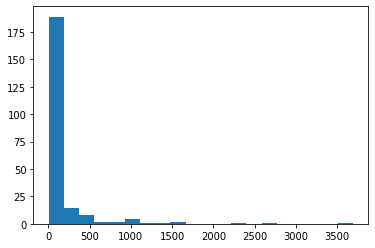

In [67]:
plt.hist(num_utts_antigun_users, bins=20)

Some people say a LOT.

(array([377.,   4.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.000000e+00, 2.697150e+03, 5.393300e+03, 8.089450e+03,
        1.078560e+04, 1.348175e+04, 1.617790e+04, 1.887405e+04,
        2.157020e+04, 2.426635e+04, 2.696250e+04, 2.965865e+04,
        3.235480e+04, 3.505095e+04, 3.774710e+04, 4.044325e+04,
        4.313940e+04, 4.583555e+04, 4.853170e+04, 5.122785e+04,
        5.392400e+04]),
 <a list of 20 Patch objects>)

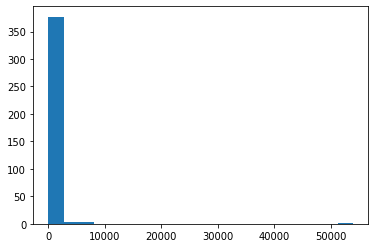

In [68]:
plt.hist(num_utts_progun_users, bins=20) # holy shit that guy at 50000

(array([356.,  13.,   4.,   5.,   2.,   0.,   2.,   1.,   1.,   2.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000e+00, 5.90200e+02, 1.17940e+03, 1.76860e+03, 2.35780e+03,
        2.94700e+03, 3.53620e+03, 4.12540e+03, 4.71460e+03, 5.30380e+03,
        5.89300e+03, 6.48220e+03, 7.07140e+03, 7.66060e+03, 8.24980e+03,
        8.83900e+03, 9.42820e+03, 1.00174e+04, 1.06066e+04, 1.11958e+04,
        1.17850e+04]),
 <a list of 20 Patch objects>)

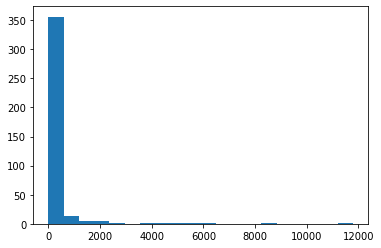

In [114]:
plt.hist(num_utts_moderate_users, bins=20) # holy shit that guy at 7500

In [115]:
import numpy as np

In [70]:
print(np.median(num_utts_antigun_users))
print(np.mean(num_utts_antigun_users))

29.5
160.50442477876106


In [71]:
print(np.median(num_utts_progun_users))
print(np.mean(num_utts_progun_users))

12.0
357.6051948051948


To normalize, we take up to 5 utterances per user. If the user has <= 5 utterances, take all of them.

In [116]:
from random import sample

In [119]:
progun_utts = []
for user in progun_users:
    user_utts = list(user.iter_utterances())
    if len(user_utts) <= 5:
        progun_utts.extend(user_utts)
    else:
        progun_utts.extend(sample(user_utts, 5))

In [120]:
antigun_utts = []
for user in antigun_users:
    user_utts = list(user.iter_utterances())
    if len(user_utts) <= 5:
        antigun_utts.extend(user_utts)
    else:
        antigun_utts.extend(sample(user_utts, 5))

In [126]:
moderate_utts = []
for user in moderate_users:
    user_utts = list(user.iter_utterances())
    if len(user_utts) <= 5:
        moderate_utts.extend(user_utts)
    else:
        moderate_utts.extend(sample(user_utts, 5))

In [125]:
len(antigun_utts)

932

In [122]:
len(progun_utts)

1487

In [127]:
len(moderate_utts)

1607

In [77]:
[utt.text for utt in antigun_utts[:10]]

['Maybe??',
 'personally, i am highly supportive of the second amendment, but one has a choice whether to carry guns on their person at a given moment while one does not have this choice when it comes to their sexuality, gender, or race. apples to oranges also i think they should be able to allow smoking so long as its clearly posted and not vented out to the side walk',
 'This is a potential issue, I agree, but then again, no solution is ever perfect.',
 "My question goes deeper than that. Why is it perceived that life is inherently good and death inherently bad. Why do we care in the first place? The arguments you are using are making these assumptions but where do these assumptions come from? I'm gonna be like a six year old and keep asking why until we get reasons we make these assumptions to build higher level arguments from. Or we could short cut and I can tell you the answer",
 "It's not desirable because of emotional attachment to life ... The very definition of beneficial is e

In [78]:
[utt.text for utt in progun_utts[:10]]

['yeah-its like that scene in DIAMONDS ARE FOREVER where Bond is stuffed in a casket inside a crematorium',
 'what "loopholes" BM members pretend stuff like the fourth amendment are "loopholes"',
 'what ruling-the commerce clause says nothing about firearms or what individuals can own or do',
 "its bad either way but its much easier to avoid a small piddly-ass town's decrees and those are never enforced anyway. Kennesaw Ga did the same thing-no one was ever arrested NYC's gun ban and sullivan law-just ask Bernie Goetz",
 'Politicians pander-it is what they do. Trump is pandering to yapping emotobabblers who want SOMETHING done.',
 "you're proving that all you want to do is whine about Trump",
 "that stupid law banned firearms that had cosmetic issues. Are you saying those massacres would not have taken place if the shooter was limited to an AR 15 that didn't have say a flash hider or a bayonet lug",
 'your crap is evidently flawed that is DICTA and the LAUTENBERG AMENDMENT allowed the 

In [10]:
def clean_text(txt):
    return txt.replace("\n", " ").replace('\x92', "'")

In [80]:
progun_text = ''
for utt in progun_utts:
    if len(utt.text) >= 25:
        if utt.text.endswith('.'):
            progun_text += clean_text(utt.text) + ' '
        else:
            progun_text += clean_text(utt.text) + '. '

In [133]:
antigun_text = ''
for utt in antigun_utts:
    if len(utt.text) >= 25:
        if utt.text.endswith('.'):
            antigun_text += clean_text(utt.text) + ' '
        else:
            antigun_text += clean_text(utt.text) + '. '

In [134]:
moderate_text = ''
for utt in moderate_utts:
    if len(utt.text) >= 25:
        if utt.text.endswith('.'):
            moderate_text += clean_text(utt.text) + ' '
        else:
            moderate_text += clean_text(utt.text) + '. '

In [12]:
from random import sample
all_text = ''
for user in forum_corpus.iter_users():
    user_utts = list(user.iter_utterances())
    user_utts = [utt for utt in user_utts if len(utt.text) >= 25]
    if len(user_utts) >= 3:
        selected_utts = sample(user_utts, 3)
    else:
        selected_utts = user_utts
    
    for utt in selected_utts:
        if utt.text.endswith('.'):
            all_text += clean_text(utt.text) + ' '
        else:
            all_text += clean_text(utt.text) + '. '

In [13]:
len(progun_text)

NameError: name 'progun_text' is not defined

In [14]:
len(antigun_text)

NameError: name 'antigun_text' is not defined

In [137]:
len(moderate_text)

718039

In [16]:
from nltk import sent_tokenize

In [85]:
with open('progun_forum_corpus_full.txt', 'w') as f:
    for sentence in sent_tokenize(progun_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

In [86]:
with open('antigun_forum_corpus_full.txt', 'w') as f:
    for sentence in sent_tokenize(antigun_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

In [142]:
os.chdir('/Users/calebchiam/Documents')

In [147]:
with open('moderate_forum_corpus_full.txt', 'w') as f:
    for sentence in sent_tokenize(moderate_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

In [17]:
with open('whole_forum_corpus_full.txt', 'w') as f:
    for sentence in sent_tokenize(all_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

## Training step

In [18]:
lm = LanguageModel(SRILM_path='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/srilm-1.7.3',
                  working_dir='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/',
                  lm_output_path='whole_forum_full.lm',
                  lm_type='laplace',
                  count_output_path='whole_forum_counts.txt',
                  order=2,
                  verbose=True)

In [19]:
lm.train('whole_forum_corpus_full.txt')

In [29]:
lm = LanguageModel(SRILM_path='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/srilm-1.7.3',
                  working_dir='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/',
                  lm_output_path='progun_forum_full.lm',
                  lm_type='laplace',
                  count_output_path='progun_forum_counts.txt',
                  order=2,
                  verbose=True)

In [30]:
lm.train('progun_forum_corpus.txt')

In [31]:
lm.str_perplexity("I love guns.")

/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/progun_forum_full.lm: line 1774: warning: non-zero probability for <unk> in closed-vocabulary LM
file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/4243935552279479169.txt: 1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -10.59516 ppl= 445.4407 ppl1= 3401.887


445.4407

In [22]:
lm.str_perplexity("I love muffins.")

/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/whole_forum_full.lm: line 3551: warning: non-zero probability for <unk> in closed-vocabulary LM
file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/131650430163317822.txt: 1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -11.41833 ppl= 715.4552 ppl1= 6398.968


715.4552

In [32]:
lm.str_perplexity("I hate guns.")

/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/progun_forum_full.lm: line 1774: warning: non-zero probability for <unk> in closed-vocabulary LM
file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/8020604061166563672.txt: 1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -11.54904 ppl= 771.3641 ppl1= 7074.231


771.3641

In [35]:
lm.str_perplexity("We ought to have a right to arm ourselves.")

/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/progun_forum_full.lm: line 1774: warning: non-zero probability for <unk> in closed-vocabulary LM
file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/1034462867550833082.txt: 1 sentences, 9 words, 0 OOVs
0 zeroprobs, logprob= -33.60268 ppl= 2292.284 ppl1= 5415.414


2292.284

In [36]:
lm.str_perplexity("We ought not have a right to arm ourselves.")

/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/progun_forum_full.lm: line 1774: warning: non-zero probability for <unk> in closed-vocabulary LM
file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/7279073632164468617.txt: 1 sentences, 9 words, 0 OOVs
0 zeroprobs, logprob= -32.24645 ppl= 1677.434 ppl1= 3827.713


1677.434

In [93]:
lm2 = LanguageModel(SRILM_path='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/srilm-1.7.3',
                  working_dir='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/',
                  lm_output_path='antigun_forum_full.lm',
                  lm_type='laplace',
                  count_output_path='antigun_forum_counts.txt',
                  order=2,
                  verbose=False)

In [94]:
lm2.train('antigun_forum_corpus_full.txt')

In [95]:
lm2.str_perplexity("I love guns.")

434.3236

In [96]:
lm2.str_perplexity("I hate guns.")

369.1392

In [49]:
lm2.str_perplexity("We have a right to arm ourselves.")

1582.907

In [50]:
lm2.str_perplexity("We do not have a right to arm ourselves.")

1348.064